In [2]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
import csv

## Create spark context

In [3]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [4]:
data_path = "s3://odl-spark19spds6003-001/ss4yd/data.csv"
pddf = pd.read_csv(data_path)
pddf = pddf.drop('Unnamed: 32', axis=1)
pddf = pddf.dropna()

In [5]:
pddf.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
df = sqlc.createDataFrame(pddf)

In [7]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius_

In [8]:
df = df.withColumnRenamed('concave points_mean','concave__points_mean')\
.withColumnRenamed('concave points_se','concave_points_se')\
.withColumnRenamed('concave points_worst','concave_points_worst')

## Write to parquet

In [10]:
parquetPath = './parquet_'
df.write.parquet(parquetPath)

## Upload parquet to s3

In [11]:
# prep list of files to transfer
bucket='odl-spark19spds6003-001'
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "ss4yd/parquet/pqt"+f)

In [12]:
df = sqlc.read.parquet(parquetPath)
df

DataFrame[id: bigint, diagnosis: string, radius_mean: double, texture_mean: double, perimeter_mean: double, area_mean: double, smoothness_mean: double, compactness_mean: double, concavity_mean: double, concave__points_mean: double, symmetry_mean: double, fractal_dimension_mean: double, radius_se: double, texture_se: double, perimeter_se: double, area_se: double, smoothness_se: double, compactness_se: double, concavity_se: double, concave_points_se: double, symmetry_se: double, fractal_dimension_se: double, radius_worst: double, texture_worst: double, perimeter_worst: double, area_worst: double, smoothness_worst: double, compactness_worst: double, concavity_worst: double, concave_points_worst: double, symmetry_worst: double, fractal_dimension_worst: double]

In [13]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- diagnosis: string (nullable = true)
 |-- radius_mean: double (nullable = true)
 |-- texture_mean: double (nullable = true)
 |-- perimeter_mean: double (nullable = true)
 |-- area_mean: double (nullable = true)
 |-- smoothness_mean: double (nullable = true)
 |-- compactness_mean: double (nullable = true)
 |-- concavity_mean: double (nullable = true)
 |-- concave__points_mean: double (nullable = true)
 |-- symmetry_mean: double (nullable = true)
 |-- fractal_dimension_mean: double (nullable = true)
 |-- radius_se: double (nullable = true)
 |-- texture_se: double (nullable = true)
 |-- perimeter_se: double (nullable = true)
 |-- area_se: double (nullable = true)
 |-- smoothness_se: double (nullable = true)
 |-- compactness_se: double (nullable = true)
 |-- concavity_se: double (nullable = true)
 |-- concave_points_se: double (nullable = true)
 |-- symmetry_se: double (nullable = true)
 |-- fractal_dimension_se: double (nullable = true)
 |-- radius

In [14]:
df.take(2)

[Row(id=842302, diagnosis='M', radius_mean=17.99, texture_mean=10.38, perimeter_mean=122.8, area_mean=1001.0, smoothness_mean=0.1184, compactness_mean=0.2776, concavity_mean=0.3001, concave__points_mean=0.1471, symmetry_mean=0.2419, fractal_dimension_mean=0.07871, radius_se=1.095, texture_se=0.9053, perimeter_se=8.589, area_se=153.4, smoothness_se=0.006399, compactness_se=0.04904, concavity_se=0.05372999999999999, concave_points_se=0.01587, symmetry_se=0.03003, fractal_dimension_se=0.006193, radius_worst=25.38, texture_worst=17.33, perimeter_worst=184.6, area_worst=2019.0, smoothness_worst=0.1622, compactness_worst=0.6656, concavity_worst=0.7119, concave_points_worst=0.2654, symmetry_worst=0.4601, fractal_dimension_worst=0.1189),
 Row(id=842517, diagnosis='M', radius_mean=20.57, texture_mean=17.77, perimeter_mean=132.9, area_mean=1326.0, smoothness_mean=0.08474, compactness_mean=0.07864, concavity_mean=0.0869, concave__points_mean=0.07017000000000001, symmetry_mean=0.1812, fractal_dime

### Look at output column

In [15]:
df.groupBy("diagnosis").count().show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        B|  357|
|        M|  212|
+---------+-----+



## Preparing the dataset

In [16]:
df = df.drop('id')

In [19]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
assemblerInputs = list(df.columns[2:])
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

labelStringIndexer = StringIndexer(inputCol = 'diagnosis', outputCol = 'label')
lstf = labelStringIndexer.fit(df)

In [24]:
df = lstf.transform(df)

In [25]:
df_vectorized = assembler.transform(df)

In [26]:
df_vectorized.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[10.38,122.8,1001...|
|[17.77,132.9,1326...|
|[21.25,130.0,1203...|
|[20.38,77.58,386....|
|[14.34,135.1,1297...|
+--------------------+
only showing top 5 rows



In [27]:
df_final = df_vectorized.select('features', 'label')

In [28]:
df_final.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[10.38,122.8,1001...|  1.0|
|[17.77,132.9,1326...|  1.0|
|[21.25,130.0,1203...|  1.0|
|[20.38,77.58,386....|  1.0|
|[14.34,135.1,1297...|  1.0|
|[15.7,82.57,477.1...|  1.0|
|[19.98,119.6,1040...|  1.0|
|[20.83,90.2,577.9...|  1.0|
|[21.82,87.5,519.8...|  1.0|
|[24.04,83.97,475....|  1.0|
|[23.24,102.7,797....|  1.0|
|[17.89,103.6,781....|  1.0|
|[24.8,132.4,1123....|  1.0|
|[23.95,103.7,782....|  1.0|
|[22.61,93.6,578.3...|  1.0|
|[27.54,96.73,658....|  1.0|
|[20.13,94.74,684....|  1.0|
|[20.68,108.1,798....|  1.0|
|[22.15,130.0,1260...|  1.0|
|[14.36,87.46,566....|  0.0|
+--------------------+-----+
only showing top 20 rows



## Split into train and test sets

In [29]:
# set seed for reproducibility
(trainingData, testData) = df_final.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 398
Test Dataset Count: 171


## Using Logistic Regression to train the model

In [31]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [32]:
lrModel = lr.fit(trainingData)

In [33]:
predictions = lrModel.transform(testData)
predictions.select("label","prediction","probability").show(n = 10, truncate = 30)

+-----+----------+------------------------------+
|label|prediction|                   probability|
+-----+----------+------------------------------+
|  0.0|       0.0|[0.7849858934079864,0.21501...|
|  0.0|       0.0|[0.6821999436006269,0.31780...|
|  0.0|       0.0|[0.9735150249297191,0.02648...|
|  1.0|       1.0|[0.2761396320767316,0.72386...|
|  0.0|       0.0|[0.9098762494682326,0.09012...|
|  0.0|       0.0|[0.9480734309135692,0.05192...|
|  0.0|       0.0|[0.9735909658323595,0.02640...|
|  0.0|       0.0|[0.800641488143218,0.199358...|
|  0.0|       0.0|[0.8097991520006629,0.19020...|
|  0.0|       0.0|[0.9415499364259298,0.05845...|
+-----+----------+------------------------------+
only showing top 10 rows



In [60]:
type(lrModel)

pyspark.ml.classification.LogisticRegressionModel

## Visualizations

* Training set ROC curve

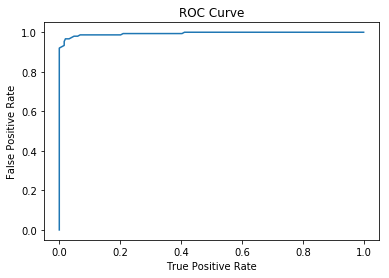

Training set areaUnderROC: 0.9942741935483873


In [37]:
roc = lrModel.summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.show()
print('Training set areaUnderROC: ' + str(lrModel.summary.areaUnderROC))

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9915655519384434


0.9915655519384434

## Testing Random Forest

In [41]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[10.89,94.28,640....|  0.0|[17.5152075677498...|[0.87576037838749...|       0.0|
|[11.28,102.8,747....|  0.0|[8.78174603174603...|[0.43908730158730...|       1.0|
|[11.79,54.34,224....|  0.0|[19.8532656864110...|[0.99266328432055...|       0.0|
|[11.89,102.5,736....|  1.0|[2.25793650793650...|[0.11289682539682...|       1.0|
|[12.39,78.85,464....|  0.0|[19.9614350084978...|[0.99807175042489...|       0.0|
|[12.74,76.84,448....|  0.0|[19.9469422548746...|[0.99734711274373...|       0.0|
|[12.83,78.83,477....|  0.0|[19.9614350084978...|[0.99807175042489...|       0.0|
|[12.87,61.49,248....|  0.0|[13.4866197752445...|[0.67433098876222...|       0.0|
|[12.96,73.16,386....|  0.0|[17.9032864419112...|[0.89516432209556...|       0.0|
|[13.04,72.23,38

In [42]:
evaluator.evaluate(predictions)

0.9896419058893164

In [49]:
rfModel.featureImportances

SparseVector(29, {0: 0.0211, 1: 0.101, 2: 0.0585, 3: 0.0025, 4: 0.0272, 5: 0.0528, 6: 0.1946, 7: 0.0031, 8: 0.0033, 9: 0.0269, 10: 0.0013, 11: 0.0095, 12: 0.0482, 13: 0.0061, 14: 0.0083, 15: 0.0011, 16: 0.0074, 17: 0.0026, 18: 0.0077, 19: 0.0313, 20: 0.0207, 21: 0.064, 22: 0.097, 23: 0.0095, 24: 0.0346, 25: 0.0387, 26: 0.1139, 27: 0.0062, 28: 0.0008})

### We see that logistic regression performs the best on the testing data set.

## More Visualizations including plotly

In [43]:
import plotly.plotly as py
import plotly.graph_objs as go

In [50]:
data = [go.Histogram(x=df.toPandas()['radius_mean'])]

In [59]:
py.plot(data)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


''